# ***CIFAR10 - Image Classifier***





---



This blog covers image classification on the CIFAR-10 image dataset. I have used CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size. The blog tuturial has been taken from below link:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py. 

Following this tutorial we will build a Convolutional Neural Network (CNN) with 2 convolutional layers that can classify the CIFAR-10 dataset. All code in part-one is referred from the pytorch tutorial

Firstly, We will create a pytorch network following with importing packages and torchvision to load CIFAR-10 dataset below:



In [42]:
#Code reference from tutorial

import torch
import torchvision
import torchvision.transforms as transforms



The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

We will download and extract the PILImage.



In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Using libraries such as matplotlib and numpy to get a representaion as well as quick idea of what data looks like.

We will print certain images from dataset

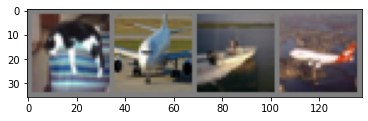

  cat plane  ship plane


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Now we need to introduce an architecture for the neural network. The network defined is a Convolution Neural Network with 2 convolutional layers(conv1 and conv2) connected to 3 fully connected layers(fc1, fc2, fc3), except the final output layer, each layer is taken through the relu-function which initializes the layer. The input convolutional layer takes a 3 channel color 32x32 image as input and looks for 6 features using a 5x5 kernel filter followed by Max Pooling with a 2x2 filter. The second convolutional layer looks for 16 features from the previous 6 using a 5x5 kernel as well. Another round of Max Pool 2 is done and the result is then flattened and fed into the 3 layer fully connected network. The fully connected network reduces the dimensionality to 120 weights then 84 and then finally 10 to predict the class. 

Below is the code for the neural network architechture:

In [45]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Now, Defined below is loss function and optimization method. 

For this Cross Entropy and Stochastic Gradient Descent is used.

Cross-Entropy Loss is useful for measuring the performance of models with output of probability values between 0 and 1.

Stochastic Gradient Descent is a form of gradient descent where weights are updated to be the old weight minus some learning rate multiplied by the gradient.

In SGD the gradient is replaced by a stochastic estimation of the gradient.

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

To train we must first do a forward pass, then do a backwards propagation to calculate the gradients and update the model parameters. 
The loss is printed every 2000 batches. The network will be trained for 2 epochs, or 2 entire loops.

In [47]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.908
[1,  6000] loss: 1.725
[1,  8000] loss: 1.594
[1, 10000] loss: 1.541
[1, 12000] loss: 1.477
[2,  2000] loss: 1.432
[2,  4000] loss: 1.377
[2,  6000] loss: 1.395
[2,  8000] loss: 1.358
[2, 10000] loss: 1.339
[2, 12000] loss: 1.333
Finished Training


Finally we need to test the network on the test dataset of 10000 images. To do this we simply just run a forward pass of the network over the test data and compare the predictions with the ground truth. Then we will record the average accuracy of all 10000 images.


In [48]:
def trial():
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          # calculate outputs by running images through the network 
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
trial()

Accuracy of the network on the 10000 test images: 54 %


The network performed with 54% accuracy on the test data. 
Finally, below is the accuracy of the predictions for each of the 10 classes.

In [49]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
acc_list=[]
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    acc_list.append(accuracy)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
print(acc_list)

Accuracy for class plane is: 56.7 %
Accuracy for class car   is: 72.4 %
Accuracy for class bird  is: 40.8 %
Accuracy for class cat   is: 27.1 %
Accuracy for class deer  is: 43.9 %
Accuracy for class dog   is: 62.7 %
Accuracy for class frog  is: 68.8 %
Accuracy for class horse is: 54.1 %
Accuracy for class ship  is: 68.7 %
Accuracy for class truck is: 45.9 %
[56.7, 72.4, 40.8, 27.1, 43.9, 62.7, 68.8, 54.1, 68.7, 45.9]


Below is the bar graph for all the accuracy of dataset with no of trials.

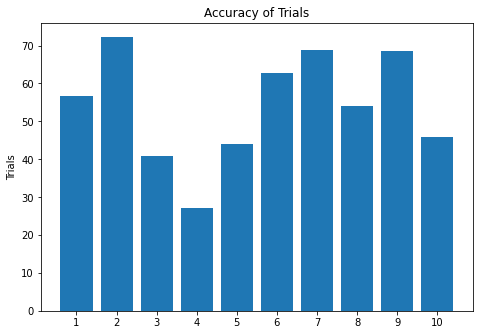

In [50]:
import matplotlib.pyplot as plt
accuracy_bar=[]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
trial = ['1','2','3','4','5','6','7','8','9','10']
ax.bar(trial,acc_list)
ax.set_ylabel('Trials')
ax.set_title('Accuracy of Trials')
plt.show()

# **CONTRIBUTION**

Secondly,Analyzing and modifying the Network

My first attempt to achieve a more accurate model was to add an additional convolutional layer that finds 32 features from the 16 channel input using a 3x3 kernel. This final layer is not pooled unlike the first and second layer.

In [51]:
import torch.nn as nn
import torch.nn.functional as F


class layer_three_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,32,3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = layer_three_net()

Adding one more layer to the network, layer 4

In [52]:
import torch.nn as nn
import torch.nn.functional as F


class layer_four_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,32,3)
        self.conv4 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = layer_four_net()

The graph to show accuracy for my experiments above:

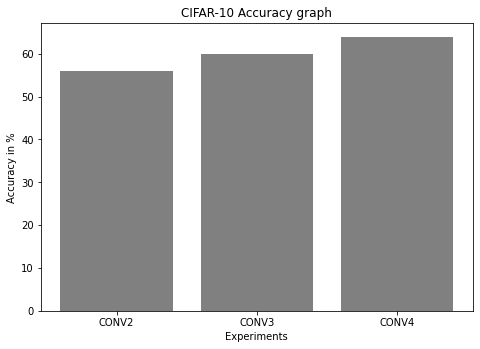

In [53]:
import matplotlib.pyplot as plt
accuracy_bar=[]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Experiment = ["CONV2", "CONV3", "CONV4"]
Accuracy_List = [54 , 60 , 64]
plt.bar(Experiment, Accuracy_List, color="grey")
ax.set_ylabel('Accuracy in %')
ax.set_xlabel('Experiments')
ax.set_title('CIFAR-10 Accuracy graph')
plt.show()